In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import sys

In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


In [ ]:
CHARS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
NUM_CLASSES = 40 # 39 + 1 blank

In [4]:
class plate_OCR(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.features = nn.Sequential(*modules)

        self.rnn = nn.LSTM(512, 128, num_layers=2, bidirectional=True, batch_first=True)
        self.classify = nn.Linear(128 * 2, NUM_CLASSES) 

    def forward(self, x):
        x = self.features(x)
        x = x.permute(0, 3, 1, 2) 
        x = x.flatten(2)
        rnn = self.rnn(x)
        result = self.classify(rnn)
        return result

In [5]:
def decode(result):
    pred = result.argmax(-1).squeeze(0).tolist()
    prev = -1
    output = []
    for p in pred:
        if p != prev and p != len(CHARS):
            output.append(CHARS[p])
        prev = p
    return ''.join(output)

In [6]:
from number_coco import license_coco
from number_coco import collate_fn
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

X_train = "../data/license_numbers/train/images"
y_train = "../data/license_numbers/train/annotations.json"

train_dataset = license_coco(root=X_train, ann_file=y_train, transforms=transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True, collate_fn=collate_fn)

{'boxes': tensor([[331., 243., 429., 534.],
        [  0.,  55.,  78., 361.],
        [ 53., 109., 136., 366.],
        [181., 166., 261., 440.],
        [404., 255., 506., 555.],
        [477., 277., 579., 585.],
        [242., 195., 334., 478.],
        [116., 138., 201., 412.]]), 'labels': tensor([18, 17, 36,  7, 14, 13, 10,  6]), 'image_id': tensor([0])}


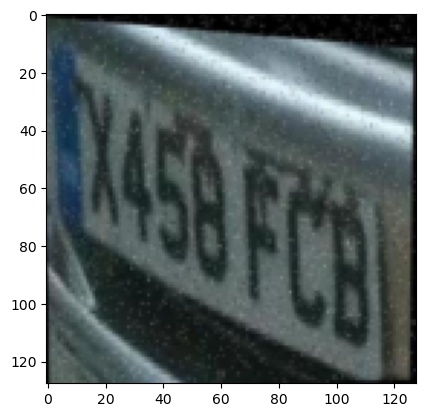

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img, target = train_dataset[0]

fig, ax = plt.subplots(1)
ax.imshow(img.permute(1, 2, 0))  # Convert from [C,H,W] to [H,W,C]
print(target)

plt.show()

In [ ]:
model = plate_OCR().to(device)
criterion = nn.CTCLoss(blank=len(CHARS), zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for images, targets, input_lengths, label_lengths in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(images)           # [B, T, C]
        outputs = outputs.permute(1, 0, 2)  # [T, B, C]

        loss = criterion(outputs, targets, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

torch.save(model.state_dict(), "number_model.pth")
